In [54]:
import xarray as xr 
import rechunker
import zarr 
import re 
import numpy as np
import shutil 
from ndpyramid import pyramid_coarsen, pyramid_reproject

- Using group = zarr.open_group to get dataset for rechunk
- using ds = xr.open_zarr() to get 'chunking' info from xarray 
- Need chunks for every variable?


In [55]:
# ds_path = 's3://carbonplan-scratch/cmip6_rechunk_test.zarr'
ds_path = 's3://carbonplan-scratch/gpcp_100MB.zarr'
group = zarr.open_consolidated(ds_path)
ds = xr.open_zarr(ds_path)
example_var = list(ds.data_vars)[0]



In [3]:
ds

<xarray.Dataset>
Dimensions:      (latitude: 180, nv: 2, longitude: 360, time: 400)
Coordinates:
    lat_bounds   (latitude, nv) float32 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * latitude     (latitude) float32 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0
    lon_bounds   (longitude, nv) float32 dask.array<chunksize=(360, 2), meta=np.ndarray>
  * longitude    (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * time         (time) datetime64[ns] 1996-10-01 1996-10-02 ... 1997-11-04
    time_bounds  (time, nv) datetime64[ns] dask.array<chunksize=(200, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    precip       (time, latitude, longitude) float32 dask.array<chunksize=(200, 180, 360), meta=np.ndarray>
Attributes: (12/45)
    Conventions:                CF-1.6, ACDD 1.3
    Metadata_Conventions:       CF-1.6, Unidata Dataset Discovery v1.0, NOAA ...
    acknowledgment:             This project was supported in part by a grant...
    cdm_data_type:              Grid
    cdr_program:                NOAA Climate Data Record Program for satellit...
    cdr_variable:               precipitation
    ...                         ...
    standard_name_vocabulary:   CF Standard Name Table (v41, 22 February 2017)
    summary:                    Global Precipitation Climatology Project (GPC...
    time_coverage_duration:     P1D
    time_coverage_end:          1996-10-01T23:59:59Z
    time_coverage_start:        1996-10-01T00:00:00Z
    title:                      Global Precipitation Climatatology Project (G...

In [56]:
spatial_chunk_square_size = 128
target_size_bytes = 5e5

def determine_chunk_size(spatial_chunk_square_size: int = 128, target_size_bytes: int = 5e5)-> int: #ex 500 KB
    return round((target_size_bytes/4)/(128*128))
time_chunk = round((target_size_bytes/4)/(128*128))


In [57]:
chunks_dict = {
    'time': (time_chunk,),
    'longitude': (spatial_chunk_square_size,),
    'latitude': (spatial_chunk_square_size,),
}
for var in ds.data_vars:
    chunks_dict[var] = {
    'time': time_chunk,
    'longitude': spatial_chunk_square_size,
    'latitude': spatial_chunk_square_size,
}



In [6]:
chunks_dict

{'time': (8,),
 'longitude': (128,),
 'latitude': (128,),
 'precip': {'time': 8, 'longitude': 128, 'latitude': 128}}

In [58]:

max_mem = '1000MB'

target_store = 'target1.zarr'
temp_store = 'temp1.zarr'
try:
    shutil.rmtree(target_store)
    shutil.rmtree(temp_store)
except:
    pass
# need to remove the existing stores or it won't work
array_plan = rechunker.rechunk(group, chunks_dict, max_mem, target_store, temp_store=temp_store)
array_plan

<Rechunked>
* Source      : <zarr.hierarchy.Group '/'>

* Intermediate: <zarr.hierarchy.Group '/'>

* Target      : <zarr.hierarchy.Group '/'>

In [59]:
array_plan.execute()

<zarr.hierarchy.Group '/'>

In [9]:
ndf = xr.open_zarr(target_store)

/var/folders/mb/7d7yq_4j2qgdfm_j3j4tsyl40000gn/T/ipykernel_67653/3386387099.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ndf = xr.open_zarr(target_store)


In [11]:
ndf

<xarray.Dataset>
Dimensions:    (latitude: 180, longitude: 360, time: 400)
Coordinates:
  * latitude   (latitude) float32 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * time       (time) datetime64[ns] 1996-10-01 1996-10-02 ... 1997-11-04
Data variables:
    precip     (time, latitude, longitude) float32 dask.array<chunksize=(8, 128, 128), meta=np.ndarray>
Attributes: (12/45)
    Conventions:                CF-1.6, ACDD 1.3
    Metadata_Conventions:       CF-1.6, Unidata Dataset Discovery v1.0, NOAA ...
    acknowledgment:             This project was supported in part by a grant...
    cdm_data_type:              Grid
    cdr_program:                NOAA Climate Data Record Program for satellit...
    cdr_variable:               precipitation
    ...                         ...
    standard_name_vocabulary:   CF Standard Name Table (v41, 22 February 2017)
    summary:                    Global Precipitation Climatology Project (GPC...
    time_coverage_duration:     P1D
    time_coverage_end:          1996-10-01T23:59:59Z
    time_coverage_start:        1996-10-01T00:00:00Z
    title:                      Global Precipitation Climatatology Project (G...

In [20]:
pyramid = pyramid_coarsen(ndf, factors=[8, 4, 2, 1], dims=['latitude', 'longitude'], boundary='trim')

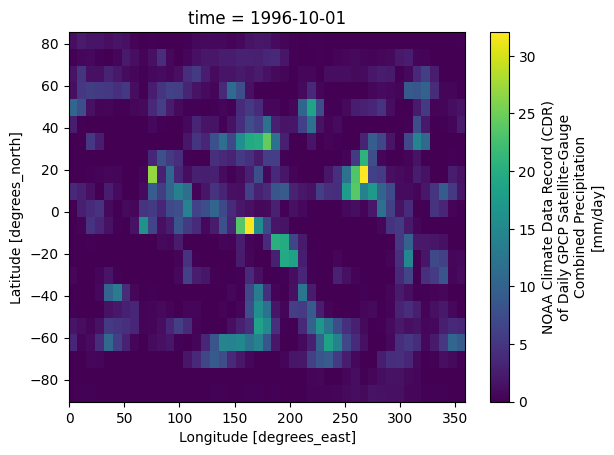

In [48]:
pyramid.children['0'].to_dataset().isel(time=0).precip.plot()

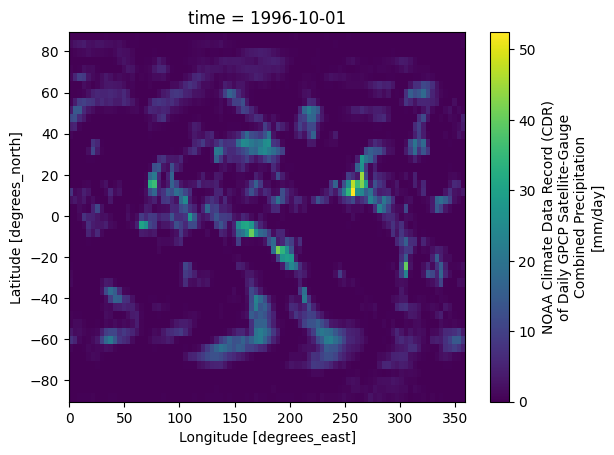

In [49]:
pyramid.children['1'].to_dataset().isel(time=0).precip.plot()

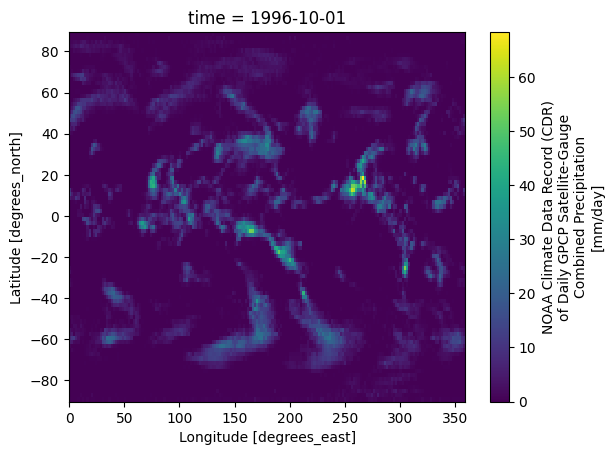

In [50]:
pyramid.children['2'].to_dataset().isel(time=0).precip.plot()

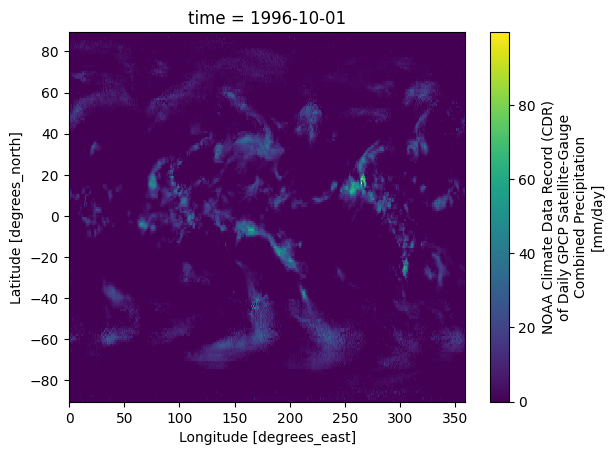

In [53]:
pyramid.children['3'].to_dataset().isel(time=0).precip.plot()